In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


## Reading Data

In [5]:
data = pd.read_csv('training_variants/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
# note the seprator in this file
data_text =pd.read_csv("training_text/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Text Processing

In [7]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [8]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 432.48154712515367 seconds


In [9]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [22]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating_Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [28]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

### Train,Test and CV split

In [29]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')


X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [30]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [31]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [32]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [33]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3,max_features =1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [12]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [13]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [14]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [15]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3190)
(number of data points * number of features) in test data =  (665, 3190)
(number of data points * number of features) in cross validation data = (532, 3190)


In [53]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [17]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [18]:

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3,max_features =1000)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point"

In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Naive Bayes

#### Hyperparameter Tuning

for alpha = 1e-05
Log Loss : 1.24332893193652
for alpha = 0.0001
Log Loss : 1.2426209181277692
for alpha = 0.001
Log Loss : 1.2415274422782412
for alpha = 0.1
Log Loss : 1.272597613853041
for alpha = 1
Log Loss : 1.3214588929144353
for alpha = 10
Log Loss : 1.5037300482734246
for alpha = 100
Log Loss : 1.4945879288264932
for alpha = 1000
Log Loss : 1.4837180430470651


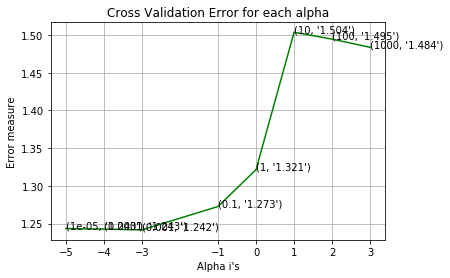

For values of best alpha =  0.001 The train log loss is: 0.49630940999911666
For values of best alpha =  0.001 The cross validation log loss is: 1.2415274422782412
For values of best alpha =  0.001 The test log loss is: 1.2161748964927448


In [20]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2415274422782412
Number of missclassified point : 0.40037593984962405
-------------------- Confusion matrix --------------------


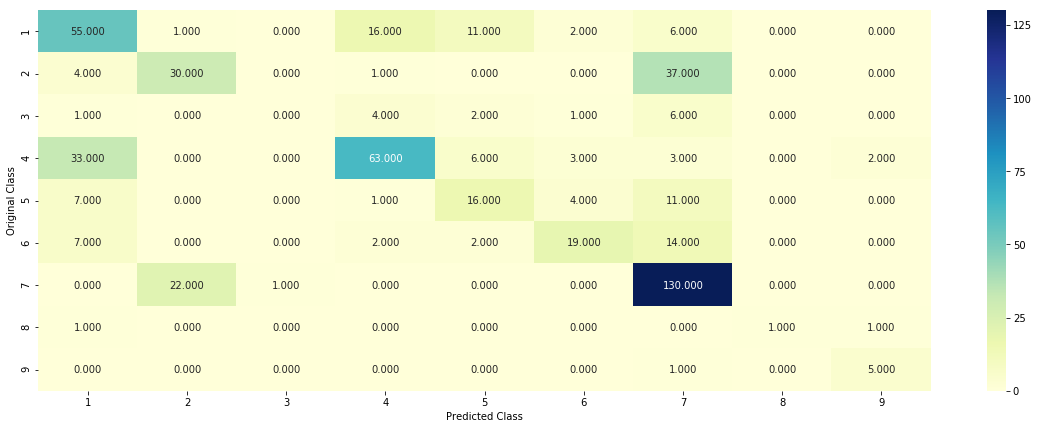

-------------------- Precision matrix (Columm Sum=1) --------------------


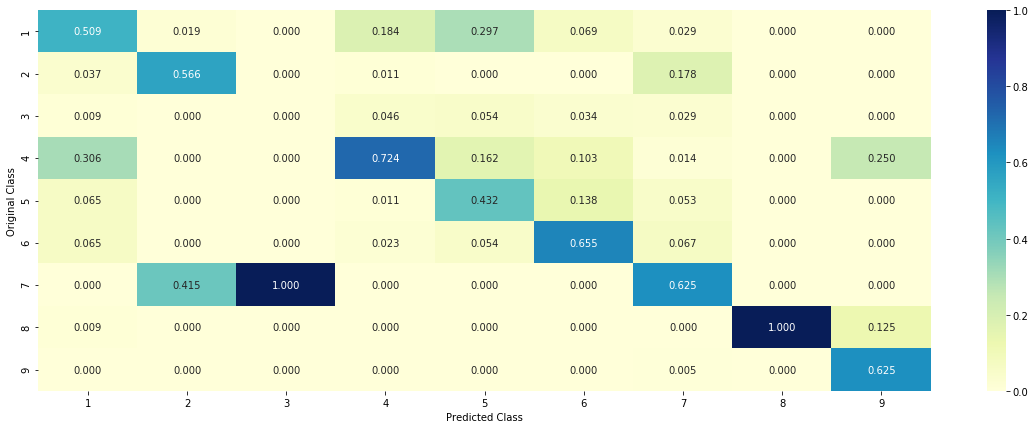

-------------------- Recall matrix (Row sum=1) --------------------


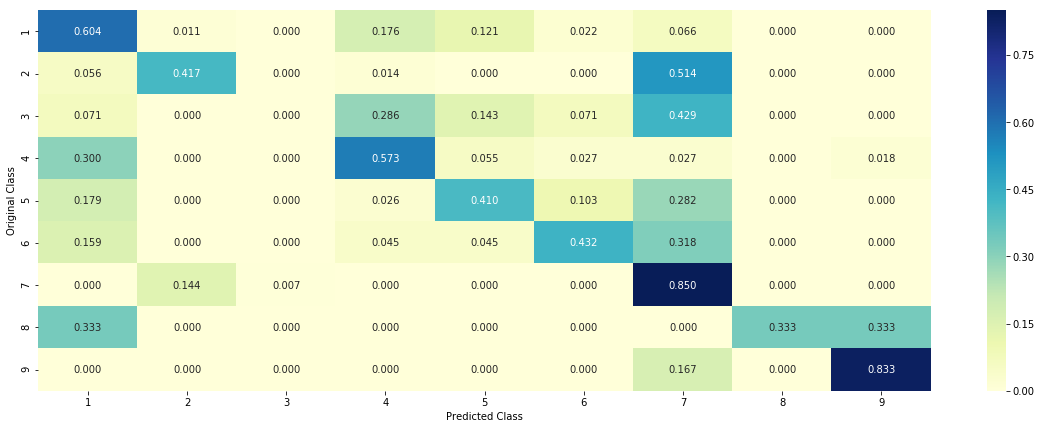

In [21]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Feature Importance

##### Correctly Classified Points

In [22]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0584 0.1991 0.0118 0.068  0.035  0.0333 0.5879 0.0039 0.0026]]
Actual Class : 6
--------------------------------------------------
15 Text feature [activation] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
22 Text feature [cells] present in test data point [True]
24 Text feature [signaling] present in test data point [True]
25 Text feature [presence] present in test data point [True]
26 Text feature [also] present in test data point [True]
29 Text feature [independent] present in test data point [True]
30 Text feature [growth] present in test data point [True]
31 Text feature [however] present in test data point [True]
32 Text feature [sensitive] present in test data point [True]
33 Text feature [factor] present in test data point [True]
36 Text feature [treatment] present in test data point [True]
37 Text feature [compared] present in test data point [True]
39 Text feature [treate

##### Incorrectly Classified Points

In [23]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0606 0.6816 0.0123 0.0712 0.0367 0.0342 0.0965 0.0041 0.0028]]
Actual Class : 7
--------------------------------------------------
15 Text feature [patients] present in test data point [True]
16 Text feature [treatment] present in test data point [True]
17 Text feature [response] present in test data point [True]
18 Text feature [clinical] present in test data point [True]
19 Text feature [months] present in test data point [True]
20 Text feature [therapy] present in test data point [True]
21 Text feature [molecular] present in test data point [True]
22 Text feature [18] present in test data point [True]
23 Text feature [15] present in test data point [True]
24 Text feature [advanced] present in test data point [True]
25 Text feature [study] present in test data point [True]
26 Text feature [time] present in test data point [True]
27 Text feature [progression] present in test data point [True]
28 Text feature [another] present in t

## K Nearest Neighbour Classification

##### Hyperparameter Tuning

for alpha = 5
Log Loss : 1.144608618107068
for alpha = 11
Log Loss : 1.1692561851541126
for alpha = 15
Log Loss : 1.2018936140589158
for alpha = 21
Log Loss : 1.1916772020321749
for alpha = 31
Log Loss : 1.2200327719012853
for alpha = 41
Log Loss : 1.249783128348374
for alpha = 51
Log Loss : 1.2743177463253206
for alpha = 99
Log Loss : 1.3593139610426426


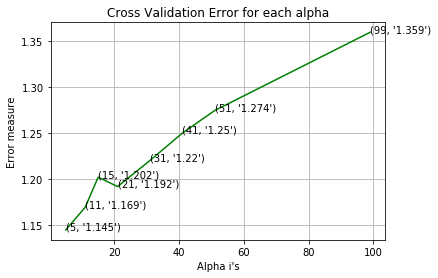

For values of best alpha =  5 The train log loss is: 0.8466975384017001
For values of best alpha =  5 The cross validation log loss is: 1.144608618107068
For values of best alpha =  5 The test log loss is: 1.1432016160130254


In [25]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the model with best hyperparameters

Log loss : 1.144608618107068
Number of mis-classified points : 0.41353383458646614
-------------------- Confusion matrix --------------------


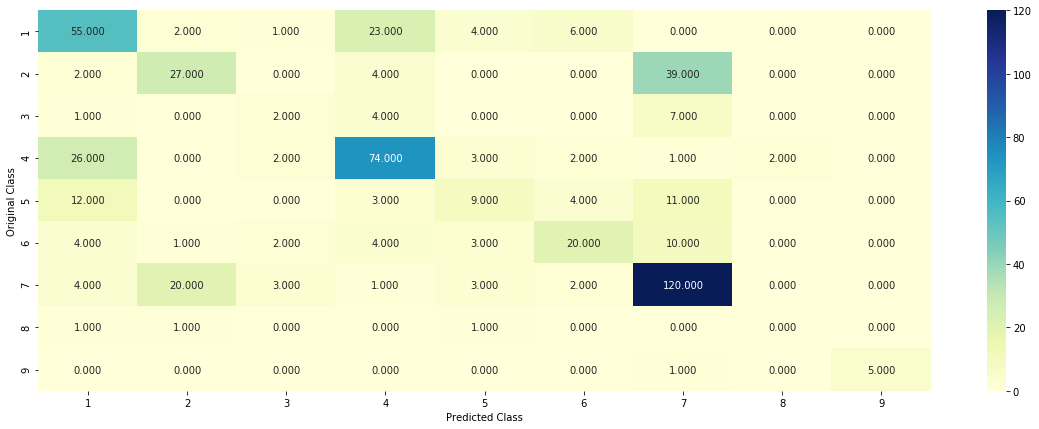

-------------------- Precision matrix (Columm Sum=1) --------------------


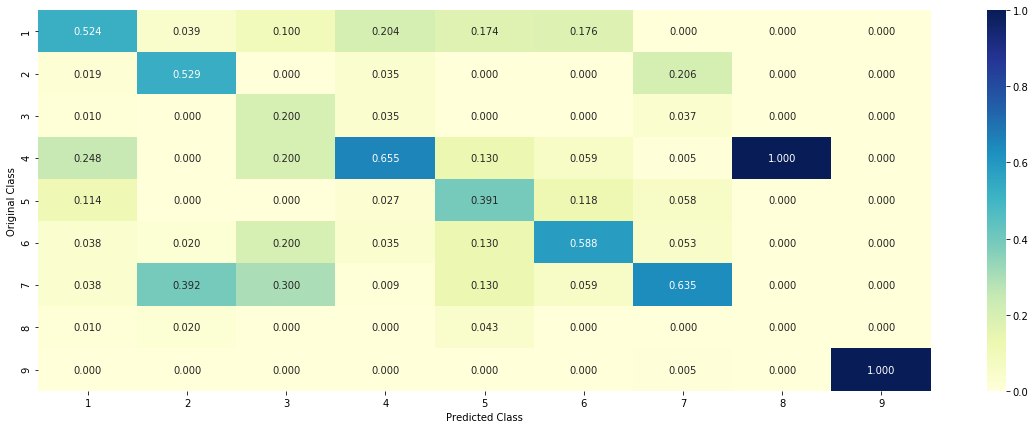

-------------------- Recall matrix (Row sum=1) --------------------


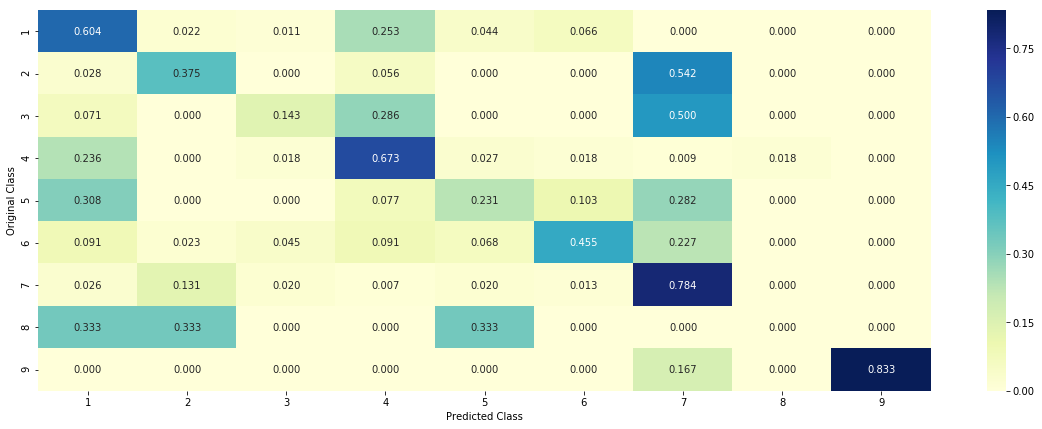

In [26]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Sample Query Point 1

In [27]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


#### Sample Query Point 2

In [28]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [7 2 7 7 7]
Fequency of nearest points : Counter({7: 4, 2: 1})


### Logistic Regression

##### With Class Balancing

for alpha = 1e-06
Log Loss : 1.209551433796208
for alpha = 1e-05
Log Loss : 1.1380750164577713
for alpha = 0.0001
Log Loss : 1.0803459223873682
for alpha = 0.001
Log Loss : 1.1006777050916157
for alpha = 0.01
Log Loss : 1.2645067766231164
for alpha = 0.1
Log Loss : 1.6653524512412254
for alpha = 1
Log Loss : 1.7927871261796793
for alpha = 10
Log Loss : 1.8089207724147218
for alpha = 100
Log Loss : 1.810802579077884


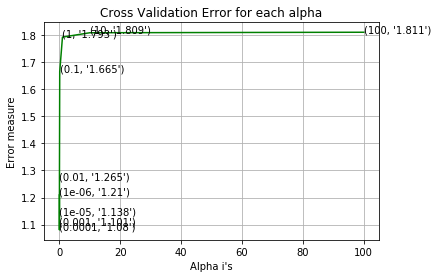

For values of best alpha =  0.0001 The train log loss is: 0.43343704043514847
For values of best alpha =  0.0001 The cross validation log loss is: 1.0803459223873682
For values of best alpha =  0.0001 The test log loss is: 1.038558372543155


In [29]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing the Model with best hyper parameters

Log loss : 1.0803459223873682
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


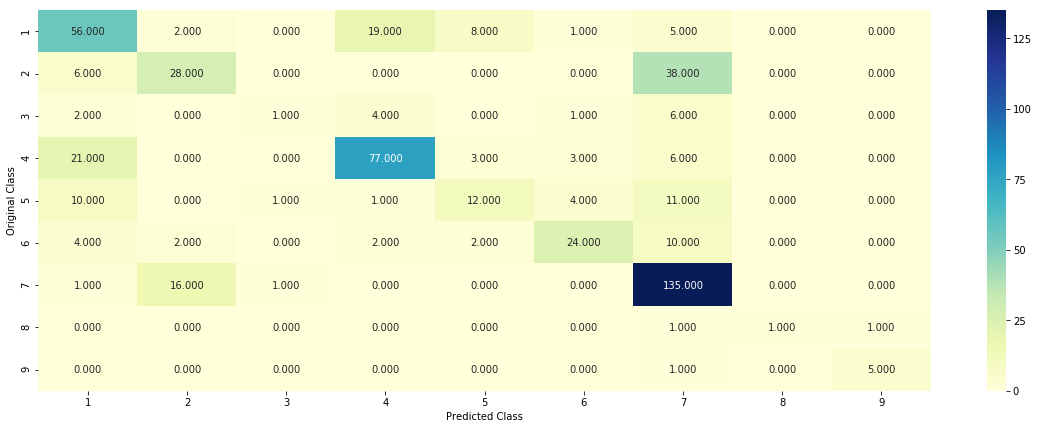

-------------------- Precision matrix (Columm Sum=1) --------------------


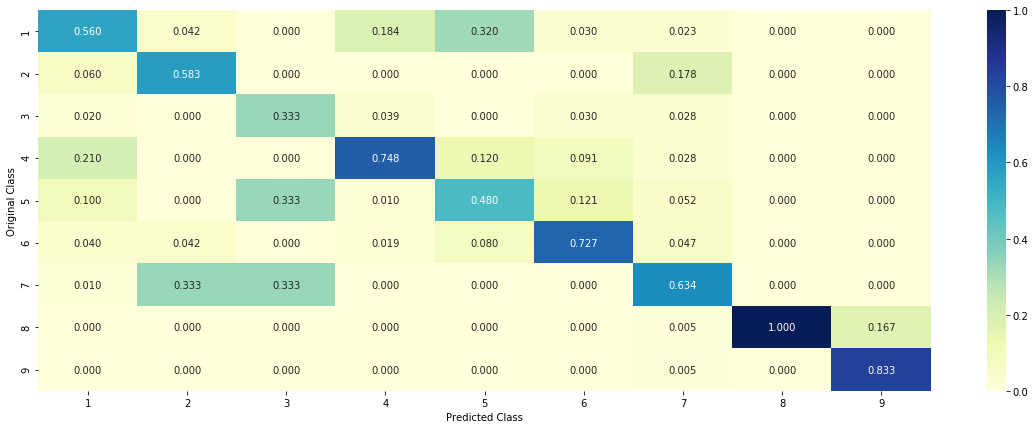

-------------------- Recall matrix (Row sum=1) --------------------


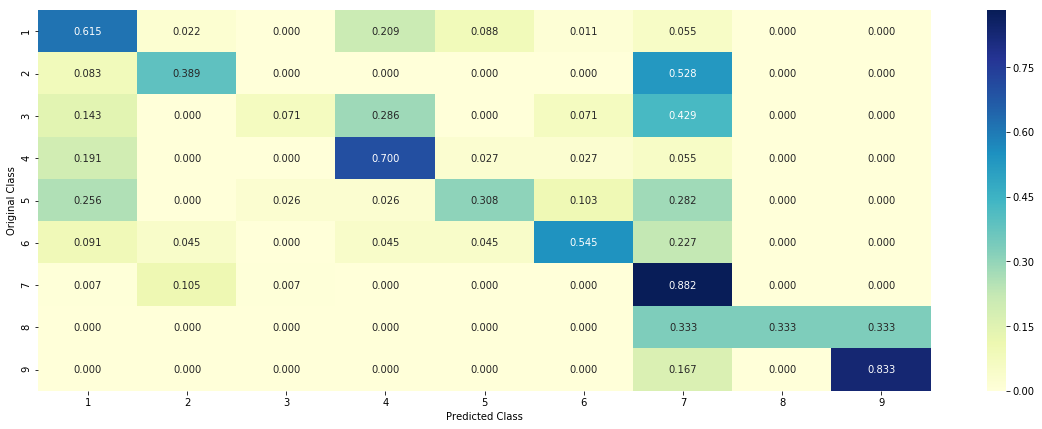

In [30]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

##### Feature Importance

In [31]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

##### Correctly Classified Point

In [34]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0585 0.2079 0.0066 0.0934 0.0355 0.0078 0.58   0.0067 0.0036]]
Actual Class : 7
--------------------------------------------------
15 Text feature [activation] present in test data point [True]
23 Text feature [transformed] present in test data point [True]
25 Text feature [oncogene] present in test data point [True]
26 Text feature [constitutive] present in test data point [True]
27 Text feature [activated] present in test data point [True]
29 Text feature [activate] present in test data point [True]
34 Text feature [bone] present in test data point [True]
36 Text feature [downstream] present in test data point [True]
37 Text feature [her2] present in test data point [True]
53 Text feature [ras] present in test data point [True]
64 Text feature [pathways] present in test data point [True]
67 Text feature [raf] present in test data point [True]
103 Text feature [transforming] present in test data point [True]
105 Text feature [colo

##### Incorrectly Classified Point

In [33]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[3.900e-03 5.307e-01 1.000e-04 4.700e-03 1.100e-03 4.000e-03 3.365e-01
  1.189e-01 0.000e+00]]
Actual Class : 7
--------------------------------------------------
145 Text feature [stable] present in test data point [True]
148 Text feature [01] present in test data point [True]
157 Text feature [hotspots] present in test data point [True]
162 Text feature [detection] present in test data point [True]
163 Text feature [fish] present in test data point [True]
168 Text feature [exons] present in test data point [True]
169 Text feature [acquired] present in test data point [True]
171 Text feature [patients] present in test data point [True]
173 Text feature [features] present in test data point [True]
181 Text feature [rearrangements] present in test data point [True]
183 Text feature [play] present in test data point [True]
187 Text feature [induce] present in test data point [True]
194 Text feature [novel] present in test data point [Tr

##### Without Class Balancing

for alpha = 1e-06
Log Loss : 1.1999705464536066
for alpha = 1e-05
Log Loss : 1.1849750730016906
for alpha = 0.0001
Log Loss : 1.0893618941936258
for alpha = 0.001
Log Loss : 1.1826746556538466
for alpha = 0.01
Log Loss : 1.605811929002338
for alpha = 0.1
Log Loss : 1.9802822290168078
for alpha = 1
Log Loss : 1.9963403603835495


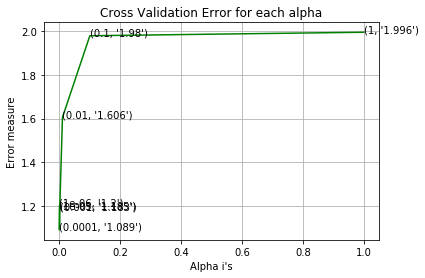

For values of best alpha =  0.0001 The train log loss is: 0.4257166936073156
For values of best alpha =  0.0001 The cross validation log loss is: 1.0893618941936258
For values of best alpha =  0.0001 The test log loss is: 1.063960432065361


In [35]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing Model with Best Hyperparameter

Log loss : 1.0893618941936258
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


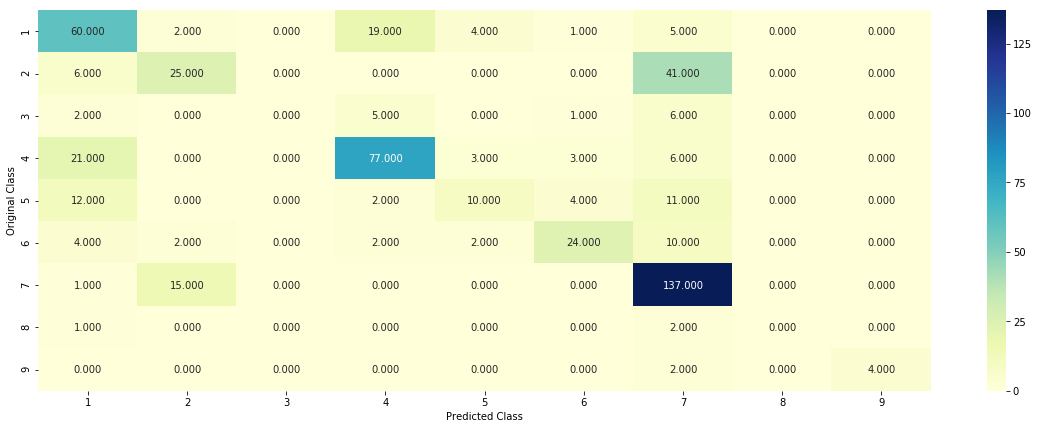

-------------------- Precision matrix (Columm Sum=1) --------------------


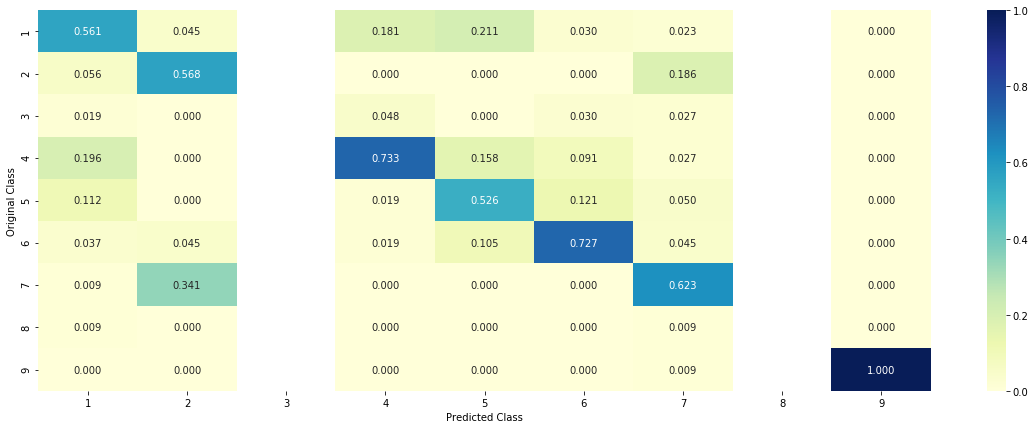

-------------------- Recall matrix (Row sum=1) --------------------


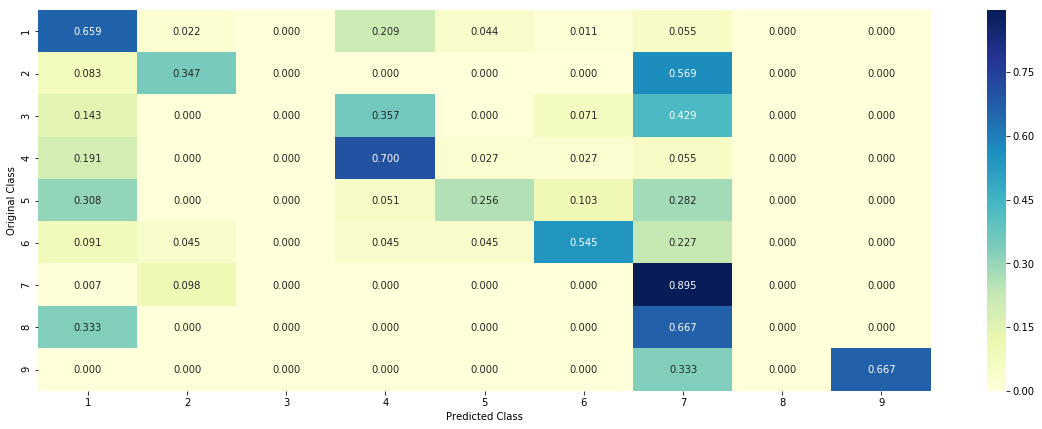

In [36]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

##### Feature Importance, Correctly classified points

In [37]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0585 0.2131 0.0073 0.0945 0.0334 0.0076 0.5775 0.0057 0.0024]]
Actual Class : 7
--------------------------------------------------
30 Text feature [her2] present in test data point [True]
32 Text feature [activation] present in test data point [True]
33 Text feature [oncogene] present in test data point [True]
38 Text feature [bone] present in test data point [True]
49 Text feature [transformed] present in test data point [True]
50 Text feature [activate] present in test data point [True]
57 Text feature [activated] present in test data point [True]
61 Text feature [constitutive] present in test data point [True]
65 Text feature [downstream] present in test data point [True]
73 Text feature [raf] present in test data point [True]
93 Text feature [ras] present in test data point [True]
140 Text feature [pathways] present in test data point [True]
147 Text feature [tissues] present in test data point [True]
164 Text feature [colony] 

##### Incorrectly classified points

In [38]:
test_point_index = 500
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.428  0.0183 0.0129 0.5164 0.0072 0.003  0.0066 0.0075 0.    ]]
Actual Class : 1
--------------------------------------------------
57 Text feature [suppressor] present in test data point [True]
91 Text feature [missense] present in test data point [True]
99 Text feature [tumorigenesis] present in test data point [True]
118 Text feature [see] present in test data point [True]
128 Text feature [heterozygous] present in test data point [True]
131 Text feature [show] present in test data point [True]
153 Text feature [comparison] present in test data point [True]
172 Text feature [dominant] present in test data point [True]
189 Text feature [families] present in test data point [True]
206 Text feature [suggesting] present in test data point [True]
208 Text feature [proportion] present in test data point [True]
222 Text feature [repair] present in test data point [True]
246 Text feature [germline] present in test data point [True]
252 T

### Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.1418261856244551
for C = 0.0001
Log Loss : 1.122618270891538
for C = 0.001
Log Loss : 1.137962078903151
for C = 0.01
Log Loss : 1.3893419575165353
for C = 0.1
Log Loss : 1.7197186507359452
for C = 1
Log Loss : 1.811236064190464
for C = 10
Log Loss : 1.8112357743048666
for C = 100
Log Loss : 1.8112361018642613


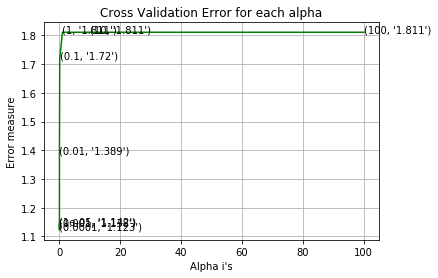

For values of best alpha =  0.0001 The train log loss is: 0.469709355880331
For values of best alpha =  0.0001 The cross validation log loss is: 1.122618270891538
For values of best alpha =  0.0001 The test log loss is: 1.0804235697985753


In [39]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing Model with Best Hyperparameter

Log loss : 1.122618270891538
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


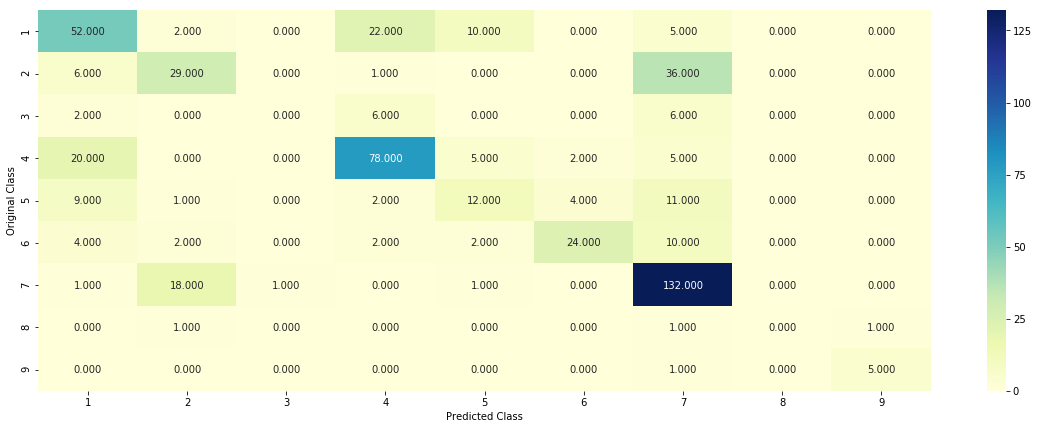

-------------------- Precision matrix (Columm Sum=1) --------------------


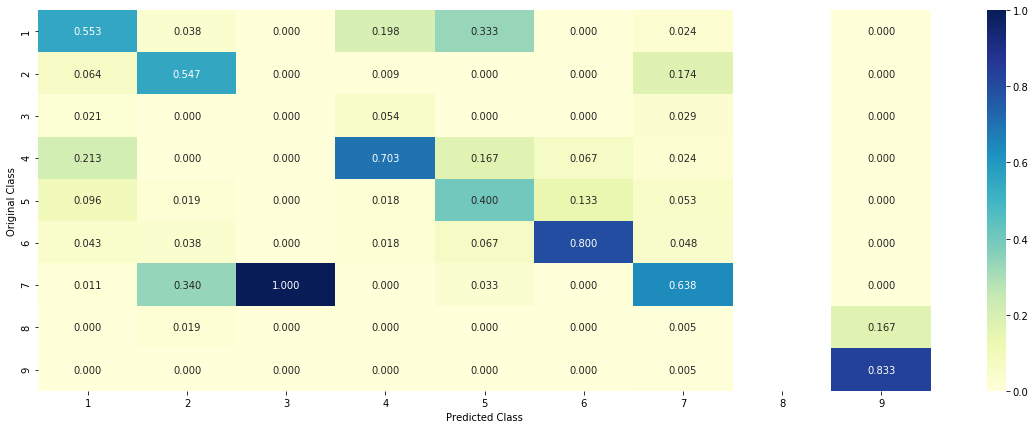

-------------------- Recall matrix (Row sum=1) --------------------


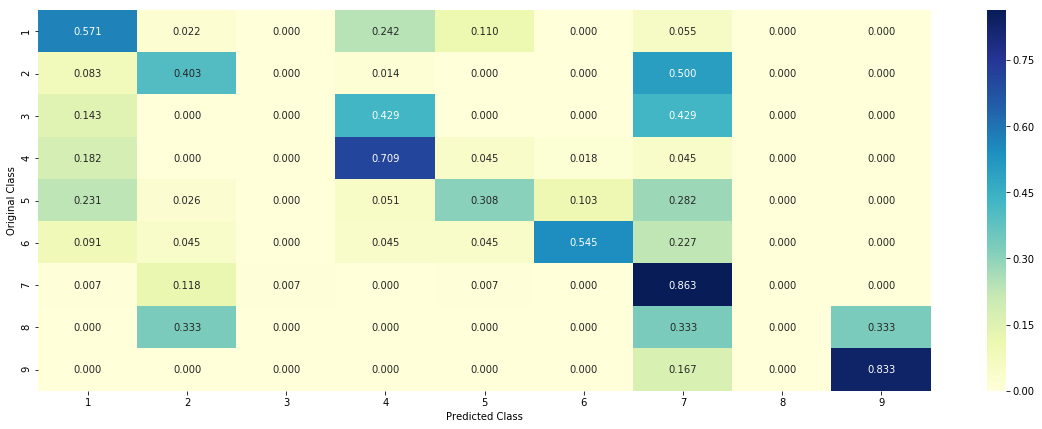

In [40]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Feature Importance

##### Correctly classified points

In [41]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1172 0.2652 0.0104 0.1036 0.0727 0.0093 0.4137 0.0054 0.0026]]
Actual Class : 7
--------------------------------------------------
31 Text feature [her2] present in test data point [True]
33 Text feature [transformed] present in test data point [True]
34 Text feature [activation] present in test data point [True]
35 Text feature [bone] present in test data point [True]
36 Text feature [oncogene] present in test data point [True]
37 Text feature [regions] present in test data point [True]
222 Text feature [activate] present in test data point [True]
223 Text feature [downstream] present in test data point [True]
225 Text feature [increased] present in test data point [True]
226 Text feature [constitutive] present in test data point [True]
227 Text feature [ras] present in test data point [True]
228 Text feature [tissues] present in test data point [True]
229 Text feature [double] present in test data point [True]
231 Text feature [a

##### Incorrectly classified points

In [42]:
test_point_index = 500
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.214e-01 4.090e-02 2.630e-02 6.261e-01 1.230e-02 9.600e-03 5.460e-02
  8.500e-03 4.000e-04]]
Actual Class : 1
--------------------------------------------------
58 Text feature [suppressor] present in test data point [True]
59 Text feature [tumorigenesis] present in test data point [True]
184 Text feature [see] present in test data point [True]
185 Text feature [comparison] present in test data point [True]
187 Text feature [missense] present in test data point [True]
190 Text feature [show] present in test data point [True]
191 Text feature [heterozygous] present in test data point [True]
193 Text feature [damage] present in test data point [True]
194 Text feature [due] present in test data point [True]
195 Text feature [cancers] present in test data point [True]
196 Text feature [dominant] present in test data point [True]
197 Text feature [proportion] present in test data point [True]
199 Text feature [regions] present in test da

### Random Forest Classifier

In [43]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2813253963625513
for n_estimators = 100 and max depth =  10
Log Loss : 1.297363291243456
for n_estimators = 200 and max depth =  5
Log Loss : 1.2725095023740634
for n_estimators = 200 and max depth =  10
Log Loss : 1.289357979753693
for n_estimators = 500 and max depth =  5
Log Loss : 1.256053921433472
for n_estimators = 500 and max depth =  10
Log Loss : 1.2808871632772836
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2488037608154785
for n_estimators = 1000 and max depth =  10
Log Loss : 1.279909905606567
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2473735095331069
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2770182711295919
For values of best estimator =  2000 The train log loss is: 0.8337888184540082
For values of best estimator =  2000 The cross validation log loss is: 1.2473735095331062
For values of best estimator =  2000 The test log loss is: 1.216013131957215


##### Testing Model with Best Hyperparameter

Log loss : 1.2473735095331067
Number of mis-classified points : 0.4417293233082707
-------------------- Confusion matrix --------------------


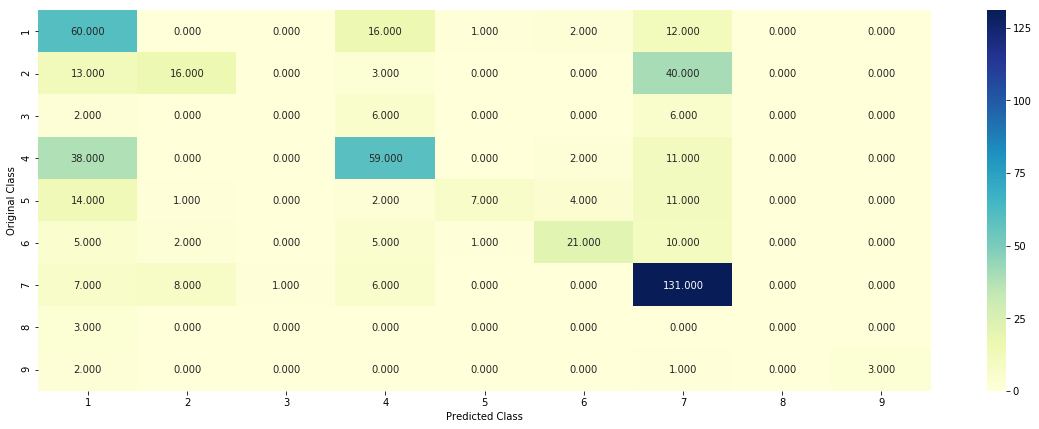

-------------------- Precision matrix (Columm Sum=1) --------------------


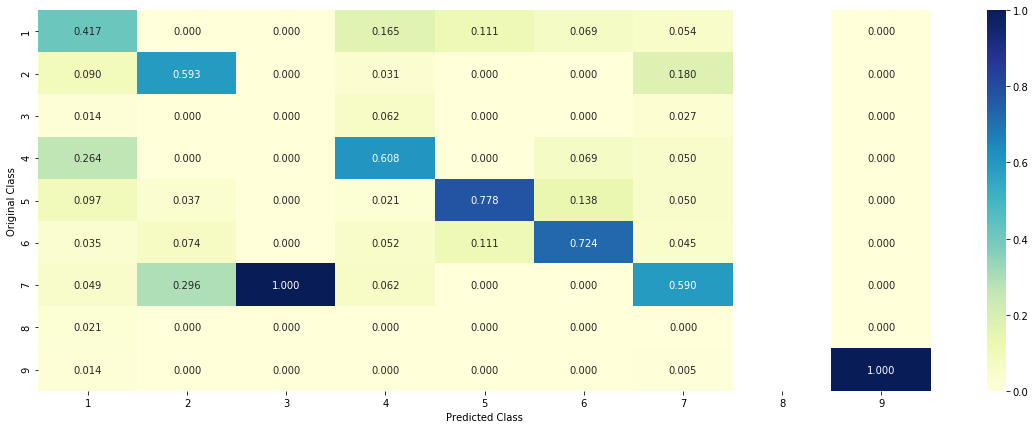

-------------------- Recall matrix (Row sum=1) --------------------


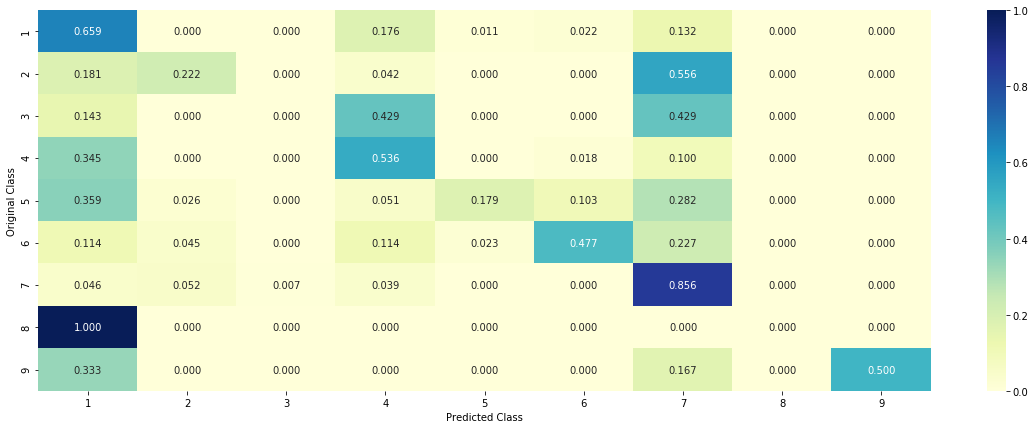

In [44]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance

##### Correctly Classified Points

In [45]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0563 0.1161 0.0258 0.112  0.0506 0.0351 0.5952 0.0059 0.003 ]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [suppressor] present in test data point [True]
8 Text feature [function] present in test data point [True]
9 Text feature [missense] present in test data point [True]
10 Text feature [constitutive] present in test data point [True]
14 Text feature [oncogenic] present in test data point [True]
15 Text feature [akt] present in test data point [True]
17 Text feature [loss] present in test data point [True]
19 Text feature [prote

##### Incorrectly classified points

In [47]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3601 0.152  0.0103 0.0499 0.0377 0.0345 0.2323 0.0857 0.0376]]
Actuall Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [inhibitors] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [suppressor] present in test data point [True]
8 Text feature [function] present in test data point [True]
10 Text feature [constitutive] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
13 Text feature [treatment] present in test data point [True]
14 Text feature [oncogenic] present in test data point [True]
15 Text 

### Stack The Models

In [48]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.81
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.032
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.512
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.221
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.490
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.004


##### Testing the model with best hyperparameter

Log loss (train) on the stacking classifier : 0.5176964457730147
Log loss (CV) on the stacking classifier : 1.221365582282291
Log loss (test) on the stacking classifier : 1.2064326704629122
Number of missclassified point : 0.3924812030075188
-------------------- Confusion matrix --------------------


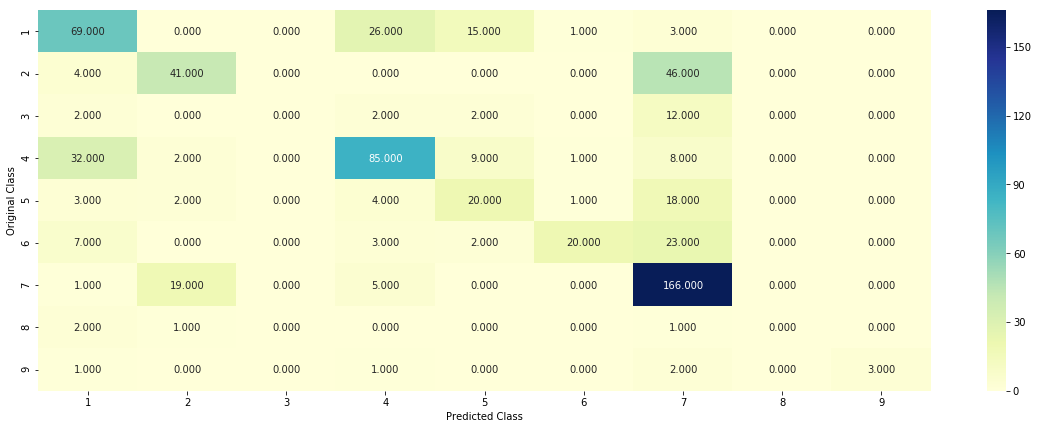

-------------------- Precision matrix (Columm Sum=1) --------------------


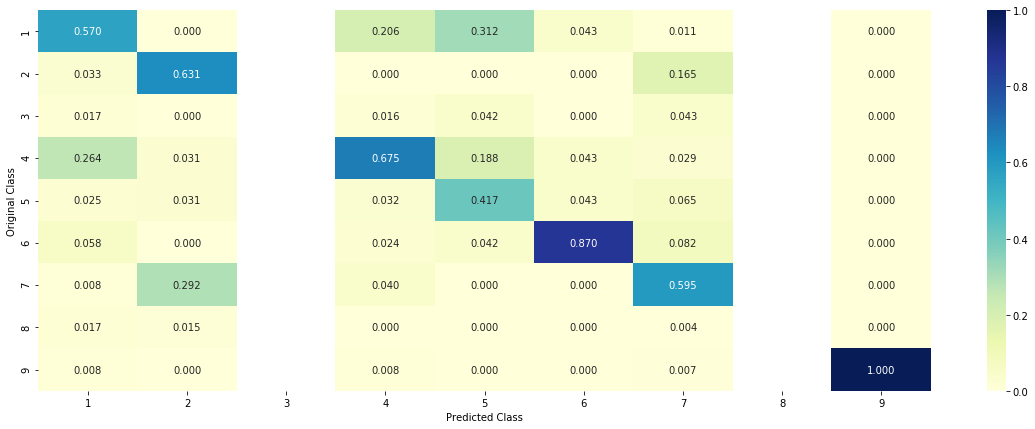

-------------------- Recall matrix (Row sum=1) --------------------


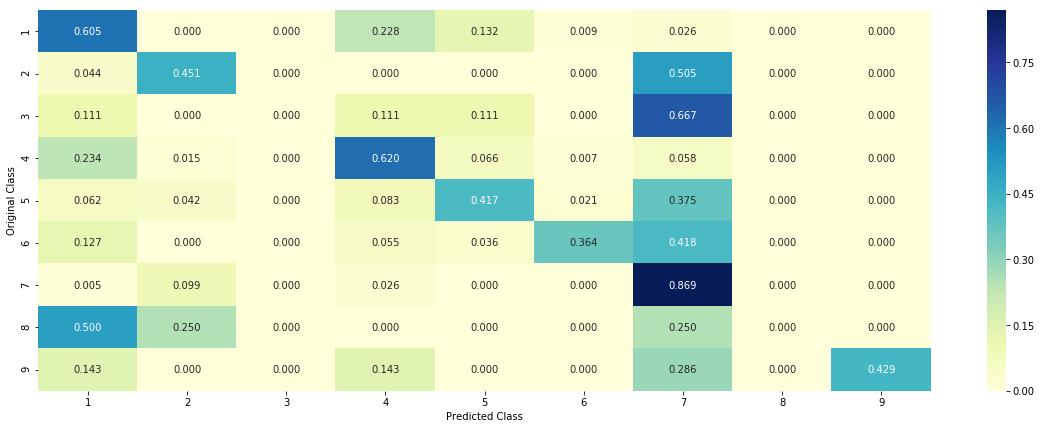

In [49]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8115798083197293
Log loss (CV) on the VotingClassifier : 1.2361773626407366
Log loss (test) on the VotingClassifier : 1.2192947713612399
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


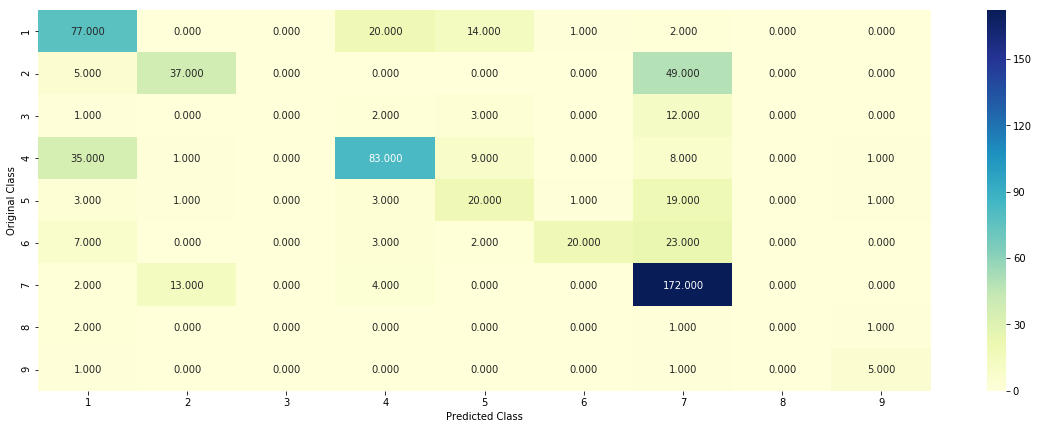

-------------------- Precision matrix (Columm Sum=1) --------------------


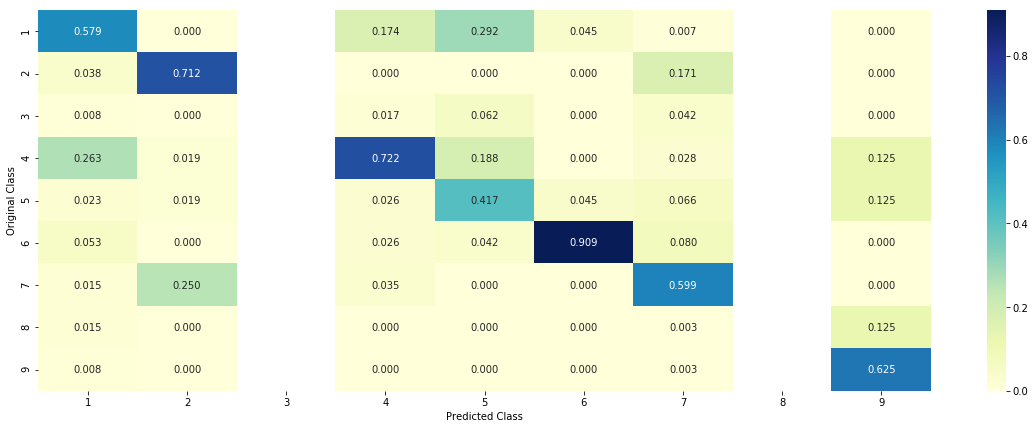

-------------------- Recall matrix (Row sum=1) --------------------


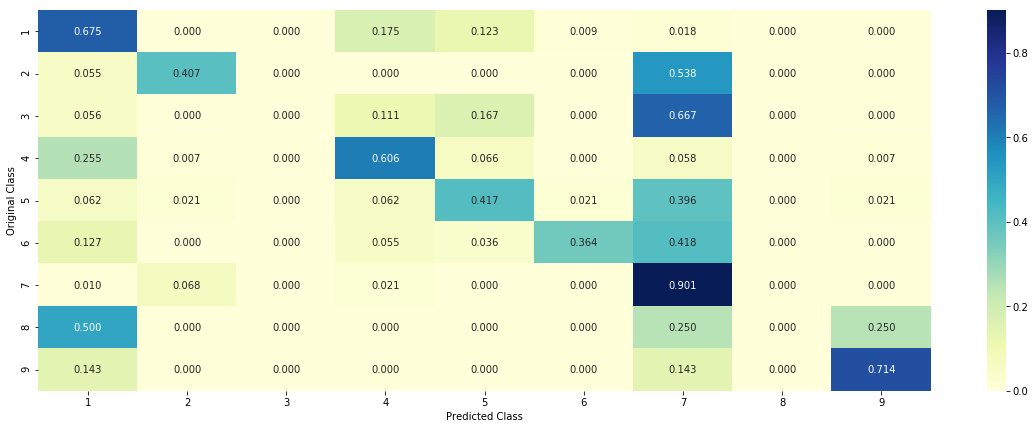

In [50]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

### Logistic Regression with Unigrams,bigrams + Feature Engineering

In [34]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [35]:
#https://www.datacamp.com/community/tutorials/categorical-data
import category_encoders as ce

encoder = ce.BinaryEncoder()
train_gene_feature_binary = encoder.fit_transform(train_df['Gene'])
test_gene_feature_binary = encoder.transform(test_df['Gene'])
cv_gene_feature_binary = encoder.transform(cv_df['Gene'])

In [36]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [37]:
encoder = ce.BinaryEncoder()
train_variation_feature_binary = encoder.fit_transform(train_df['Variation'])
test_variation_feature_binary = encoder.transform(test_df['Variation'])
cv_variation_feature_binary = encoder.transform(cv_df['Variation'])

In [67]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1,1))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of features in train data :", len(train_text_features))

Total number of features in train data : 53398


In [57]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [58]:
train_y = np.array(list(train_df['Class']))

test_y = np.array(list(test_df['Class']))

cv_y = np.array(list(cv_df['Class']))


In [42]:
from sklearn.feature_selection import SelectKBest, chi2
train_text_feature_onehotCoding=SelectKBest(score_func=chi2,k=2000).fit_transform(train_text_feature_onehotCoding,train_y)
print(train_text_feature_onehotCoding.shape)

test_text_feature_onehotCoding=SelectKBest(score_func=chi2,k=2000).fit_transform(test_text_feature_onehotCoding,test_y)
print(test_text_feature_onehotCoding.shape)

cv_text_feature_onehotCoding=SelectKBest(score_func=chi2,k=2000).fit_transform(cv_text_feature_onehotCoding,cv_y)
print(cv_text_feature_onehotCoding.shape)

(2124, 2000)
(665, 2000)
(532, 2000)


In [68]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(2,2))
train_text_feature_2grams = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_2grams.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of features in train data :", len(train_text_features))

Total number of features in train data : 726535


In [60]:
# don't forget to normalize every feature
train_text_feature_2grams = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_2grams = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_2grams = normalize(test_text_feature_2grams, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_2grams = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_2grams = normalize(cv_text_feature_2grams, axis=0)

In [45]:
from sklearn.feature_selection import SelectKBest, chi2
train_text_feature_2grams=SelectKBest(score_func=chi2,k=2000).fit_transform(train_text_feature_2grams,train_y)
print(train_text_feature_2grams.shape)

test_text_feature_2grams=SelectKBest(score_func=chi2,k=2000).fit_transform(test_text_feature_2grams,test_y)
print(test_text_feature_2grams.shape)

cv_text_feature_2grams=SelectKBest(score_func=chi2,k=2000).fit_transform(cv_text_feature_2grams,cv_y)
print(cv_text_feature_2grams.shape)

(2124, 2000)
(665, 2000)
(532, 2000)


### Featurization

In [61]:
text_vectorizer = TfidfVectorizer(min_df=3,ngram_range =(3,3),max_features = 2000)

train_text_features_3grams = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features_3grams = normalize(train_text_features_3grams, axis=0)

test_text_features_3grams = text_vectorizer.transform(test_df['TEXT'])

test_text_features_3grams = normalize(test_text_features_3grams, axis=0)

cv_text_features_3grams = text_vectorizer.transform(cv_df['TEXT'])

cv_text_features_3grams = normalize(cv_text_features_3grams, axis=0)

text_vectorizer = TfidfVectorizer(min_df=3,ngram_range =(4,4),max_features = 2000)

train_text_features_4grams = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features_4grams = normalize(train_text_features_4grams, axis=0)

test_text_features_4grams = text_vectorizer.transform(test_df['TEXT'])

test_text_features_4grams = normalize(test_text_features_4grams, axis=0)

cv_text_features_4grams = text_vectorizer.transform(cv_df['TEXT'])

cv_text_features_4grams = normalize(cv_text_features_4grams, axis=0)

In [62]:
text_vectorizer = TfidfVectorizer(min_df=3,ngram_range =(5,5),max_features = 2000)

train_text_features_5grams = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features_5grams = normalize(train_text_features_5grams, axis=0)

test_text_features_5grams = text_vectorizer.transform(test_df['TEXT'])

test_text_features_5grams = normalize(test_text_features_5grams, axis=0)

cv_text_features_5grams = text_vectorizer.transform(cv_df['TEXT'])

cv_text_features_5grams = normalize(cv_text_features_5grams, axis=0)

##### length of text for each gene

In [265]:
train_length_onehotCoding = normalize(np.sum(train_text_feature_onehotCoding,axis = 1),axis=0)
print(train_length_onehotCoding.shape)
test_length_onehotCoding = normalize(np.sum(test_text_feature_onehotCoding,axis=1),axis=0)
print(test_length_onehotCoding.shape)
cv_length_onehotCoding = normalize(np.sum(cv_text_feature_onehotCoding,axis=1),axis=0)
print(cv_length_onehotCoding.shape)

(2124, 1)
(665, 1)
(532, 1)


In [266]:
train_length_3grams= normalize(np.sum(train_text_features_3grams,axis=1),axis=0)
print(train_length_3grams.shape)
test_length_3grams = normalize(np.sum(test_text_features_3grams,axis=1),axis=0)
print(test_length_3grams.shape)
cv_length_3grams = normalize(np.sum(cv_text_features_3grams,axis=1),axis=0)
print(cv_length_3grams.shape)
train_length_4grams= normalize(np.sum(train_text_features_4grams,axis=1),axis=0)
print(train_length_4grams.shape)
test_length_4grams = normalize(np.sum(test_text_features_4grams,axis=1),axis=0)
print(test_length_4grams.shape)
cv_length_4grams = normalize(np.sum(cv_text_features_4grams,axis=1),axis=0)
print(cv_length_4grams.shape)

(2124, 1)
(665, 1)
(532, 1)
(2124, 1)
(665, 1)
(532, 1)


##### Stacking of features

In [63]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding,train_text_feature_2grams,train_text_features_3grams,train_text_features_4grams)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding,test_text_feature_2grams,test_text_features_3grams,test_text_features_4grams)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding,cv_text_feature_2grams,cv_text_features_3grams,cv_text_features_4grams)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [64]:
print(train_x_onehotCoding.shape)
print(test_x_onehotCoding.shape)
print(cv_x_onehotCoding.shape)

(2124, 10181)
(665, 10181)
(532, 10181)


### Logistic Regression

for alpha = 1e-06
Log Loss : 1.1918457637077637
for alpha = 1e-05
Log Loss : 1.2017434612572404
for alpha = 0.0001
Log Loss : 1.0741443543826876
for alpha = 0.001
Log Loss : 1.0465521381075888
for alpha = 0.01
Log Loss : 1.1652545571321893
for alpha = 0.1
Log Loss : 1.5932650012703873
for alpha = 1
Log Loss : 1.7268180683146033
for alpha = 10
Log Loss : 1.744140662440779
for alpha = 100
Log Loss : 1.746000461492829


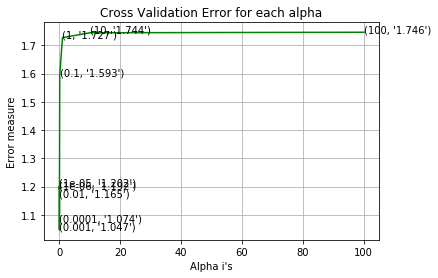

For values of best alpha =  0.001 The train log loss is: 0.5996369060097327
For values of best alpha =  0.001 The cross validation log loss is: 1.0465521381075888
For values of best alpha =  0.001 The test log loss is: 0.9995513560456347


In [65]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42,n_jobs=-1,learning_rate='optimal')
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,n_jobs=-1,learning_rate='optimal')
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Conclusion

1. First we read the data and process the text for stopwords and special characters and null description, replace the null description with Gene+Variation.
2. split the data for train,test and cv - 64 , 20 ,16 percents respectively
3. Encode the Gene,variation with one hot encoding and text with TfIDf encoding, normalize the data and stack them using hstack
4. Define the functions for predict and plot confusion matrix, report logloss and get important features.
5. First Model: Naive Bayes
6. perform hyperparameter tuning and plot cv error for each alpha.Naive bayes is the baseline model and it obtained a trainloss of - 0.49 cv loss of 1.24, test loss of 1.21 , obtained the feature importance for correctly classified points and incorrectly classified points.
7. Second Model : K-NN Classifier.
8. perform hyperparameter tuning and plot cv error for each alpha. K-NN Classifier obtained a trainloss of - 0.84 cv loss of 1.14, test loss of 1.14, obtained the feature importance for correctly classified points and incorrectly classified points.
9. Third Model : Logistic Regression with class Balancing
10. perform hyperparameter tuning and plot cv error for each alpha.Logistic Regression obtained a trainloss of - 0.43 cv loss of 1.08, test loss of 1.03, obtained the feature importance for correctly classified points and incorrectly classified points.
11. Fourth Model : Logistic Regression with out class balancing
12. perform hyperparameter tuning and plot cv error for each alpha.Logistic Regression with out class balancing obtained a trainloss of - 0.42 cv loss of 1.08, test loss of 1.06, obtained the feature importance for correctly classified points and incorrectly classified points.
13. Fifth Model : Linear Support Vector Machines
14. perform hyperparameter tuning and plot cv error for each alpha.SVM obtained a trainloss of - 0.46 cv loss of 1.12, test loss of 1.08, obtained the feature importance for correctly classified points and incorrectly classified points.
15. Sixth Model : Random Forest
16. perform hyperparameter tuning and plot cv error for each alpha.Randomforest obtained a trainloss of - 0.83 cv loss of 1.24, test loss of 1.21, obtained the feature importance for correctly classified points and incorrectly classified points.
17. Seventh Model : Stacking Models with SGDClassifier(Log loss, Hinge Loss) + Multinomial NaiveBayes
18. perform hyperparameter tuning and plot cv error for each alpha.Stacking Model obtained a trainloss of - 0.51 cv loss of 1.22, test loss of 1.20, obtained the feature importance for correctly classified points and incorrectly classified points.
19. Eight Model : Maximum Voting Classifier
20. perform hyperparameter tuning and plot cv error for each alpha.Maximum Voting Classifier obtained a trainloss of - 0.81 cv loss of 1.23, test loss of 1.21, obtained the feature importance for correctly classified points and incorrectly classified points.
21. Nineth Model : Logistic Regression with Unigrams,Bigrams + Feature Engineering.
22. perform hyperparameter tuning and plot cv error for each alpha.Logistic Regression obtained a trainloss of - 0.59 cv loss of 1.04, test loss of 0.99, obtained the feature importance for correctly classified points and incorrectly classified points.
23. Coming to the feature engineering part we have used 3-gram and 4-gram tfidf vectors with constraining the no.of features to 2000 each, we also constrained the unigram and bigram features to 2000 each and we used selectkbest for selecting the best features

In [78]:
from prettytable import PrettyTable
import prettytable as pt
x = PrettyTable()
x.hrules = pt.ALL
x.field_names = ["Model","Train Log Loss","CV Log Loss","Test Logloss"]
x.add_row(["Naive Bayes",0.49,1.24,1.21])
x.add_row(["KNN - Classifier",0.84,1.14,1.14])
x.add_row(["Logistic Regression with Class Balancing",0.43,1.08,1.03])
x.add_row(["Logistic Regression with out class balancing",0.42,1.08,1.06])
x.add_row(["Linear SVM",0.46,1.12,1.08])
x.add_row(["Random Forest",0.83,1.24,1.21])
x.add_row(["Stacking Models",0.51,1.22,1.20])
x.add_row(["Maximum Voting Classifier",0.81,1.23,1.21])
x.add_row(["Logistic Regression with Unigram,Bigram, Feature Egineering",0.59,1.04,0.99])
print(x)

+-------------------------------------------------------------+----------------+-------------+--------------+
|                            Model                            | Train Log Loss | CV Log Loss | Test Logloss |
+-------------------------------------------------------------+----------------+-------------+--------------+
|                         Naive Bayes                         |      0.49      |     1.24    |     1.21     |
+-------------------------------------------------------------+----------------+-------------+--------------+
|                       KNN - Classifier                      |      0.84      |     1.14    |     1.14     |
+-------------------------------------------------------------+----------------+-------------+--------------+
|           Logistic Regression with Class Balancing          |      0.43      |     1.08    |     1.03     |
+-------------------------------------------------------------+----------------+-------------+--------------+
|         